In [1]:
from textwrap import indent

from IPython.display import Javascript

from liblet import ANTLR, AnnotatedTreeWalker, Tree, pyast2tree, side_by_side, Stack

from operator import add, mul, truediv, sub

from operator import itemgetter

from IPython.display import Latex

from fractions import Fraction

from block_depth import BlockDepth


In [2]:
init_block = BlockDepth()
curly1 = init_block.add_block(BlockDepth.CURLY)
round1 = curly1.add_block(BlockDepth.ROUND)

curly2 = init_block.add_block(BlockDepth.CURLY)
round2 = curly2.add_block(BlockDepth.ROUND)
print(round2 > curly2)




True


In [3]:
ArithmeticExpr = ANTLR(r"""
grammar arithmetic;
ignoblebug: expr;

s : expr EOF;



expr                                                      // TODO: parentesizzazione semplice efficiente
   : (PLUS | MINUS)? (INT|RAT|REAL)   # atomExpr
   | <assoc=right>expr POW expr           # powExpr
   | expr FRACT expr                      # FractExpr
   | (PLUS | MINUS) expr                  # unaryExpr
   | expr (TIMES | DIV) expr              # divProdExpr
   | expr (PLUS | MINUS) expr             # addSubExpr
   | ROUND_L_BRACK expr ROUND_R_BRACK     # roundBlockExpr
   | CURLY_L_BRACK expr CURLY_R_BRACK     # curlyBlockExpr
   | SQUARE_L_BRACK expr SQUARE_R_BRACK   # squareBlockExpr
   | ROUND_L_BRACK expr ROUND_R_BRACK     # roundBlockExpr
   | SUBEXP_L_BRACK expr SUBEXP_R_BRACK   # subExpr
   ;


INT
   : NUM 
   ;
   
RAT
    : NUM FRACT NUM
    ;

REAL
   : NUM ('.' NUM +)? (E SIGN? NUM)?
   ;
   
NUM
   :  ('0' .. '9') + (('0' .. '9') +)?
   ;   


fragment E
   : 'E' | 'e'
   ;
   
fragment SIGN
   : ('+' | '-')
   ;
   
CURLY_L_BRACK : '{' ;
CURLY_R_BRACK : '}' ;
SQUARE_L_BRACK : '[' ;
SQUARE_R_BRACK : ']' ;
ROUND_L_BRACK : '(' ;
ROUND_R_BRACK : ')' ;
SUBEXP_L_BRACK : '<' ;
SUBEXP_R_BRACK : '>' ;
PLUS   : '+' ;
MINUS  : '-' ;
TIMES  : 'x' ;
DIV    : ':' ;
POINT  : '.' ;
POW    : '^' ;
FRACT  : '/' ;

WS
   : [ \r\n\t] + -> skip
   ;
   

""")

In [4]:
latex_formatter = AnnotatedTreeWalker.load('latexFormatter.atw')

In [5]:
expr = """
-<1+3>/<2^<1+4>-6>
"""
ptree = ArithmeticExpr.tree(expr, 's')
#ptree

ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2


In [6]:
arith2ast = AnnotatedTreeWalker('name')

PRIORITY = {
    'powExpr' : 5,
    'fractExpr' : 3,
    'unaryExpr' : 4,
    'divProdExpr' : 2,
    'addSubExpr' : 1
}


@arith2ast.register
def RAT(visit, ptree):
    return Fraction(ptree.root['value'])

@arith2ast.register
def INT(visit, ptree):
    return int(ptree.root['value'])

@arith2ast.register
def REAL(visit, ptree):
    return float(ptree.root['value'])

@arith2ast.register
def atomExpr(visit, ptree):
    if len(ptree.children) > 1:
        value = -visit(ptree.children[1])
    else:
        value = visit(ptree.children[0])
    return Tree({'type': 'atomExpr', 'value': value, 'priority': 0}, [])

@arith2ast.register
def addSubExpr(visit, ptree):
    left, op, right = ptree.children
    left = visit(left)
    right = visit(right)
    
    priority = max(PRIORITY['addSubExpr'], left.root['priority'], right.root['priority'])
    
    return Tree({'type': 'addSubExpr', 'op': op.root['value'], 'priority': priority}, [left, right])


@arith2ast.register
def divProdExpr(visit, ptree):
    left, op, right = ptree.children
    left = visit(left)
    right = visit(right)
    
    priority = max(PRIORITY['divProdExpr'], left.root['priority'], right.root['priority'])

    return Tree({'type': 'divProdExpr', 'op': op.root['value'], 'priority': priority}, [left, right])


@arith2ast.register
def powExpr(visit, ptree):
    left, _, right = ptree.children
    left = visit(left)
    right = visit(right)
    
    priority = max(PRIORITY['powExpr'], left.root['priority'], right.root['priority'])

    return Tree({'type': 'powExpr', 'priority': priority}, [left, right])

@arith2ast.register
def unaryExpr(visit, ptree):
    op, subexpr = ptree.children
    subexpr = visit(subexpr)
    
    priority = max(PRIORITY['unaryExpr'], subexpr.root['priority'])

    return Tree({'type': 'unaryExpr', 'op': op.root['value'], 'priority': priority}, [subexpr])



@arith2ast.register
def fractExpr(visit, ptree):
    left, _, right = ptree.children
    left = visit(left)
    right = visit(right)

    priority = max(PRIORITY['fractExpr'], left.root['priority'], right.root['priority'])
    
    return Tree({'type': 'fractExpr', 'priority': priority}, [left, right])


@arith2ast.register
def roundBlockExpr(visit, ptree):
    _, subexpr, _ = ptree.children
    subexpr = visit(subexpr)
    
    return Tree({'type': 'roundBlockExpr', 'priority': 0}, [subexpr])


@arith2ast.register
def squareBlockExpr(visit, ptree):
    _, subexpr, _ = ptree.children
    subexpr = visit(subexpr)
    
    return Tree({'type': 'squareBlockExpr', 'priority': 0}, [subexpr])

    
@arith2ast.register
def curlyBlockExpr(visit, ptree):
    _, subexpr, _ = ptree.children
    subexpr = visit(subexpr)
    
    return Tree({'type': 'curlyBlockExpr', 'priority': 0}, [subexpr])

@arith2ast.register
def subExpr(visit, ptree):
    _, subexpr, _ = ptree.children
    return visit(subexpr)
    
@arith2ast.register
def s(visit, ptree):
    expr = visit(ptree.children[0])
    return Tree({'type': 'main'}, [expr])



In [16]:
atw_blocks = AnnotatedTreeWalker('type', AnnotatedTreeWalker.RECOURSE_CHILDREN)

@atw_blocks.catchall
def catchall(visit, ast):
    blocks = []
    children = []
    for child in ast.children:
        t, b = visit(child)
        children.append(t)
        blocks = blocks + b
    return Tree(ast.root, children), blocks

    #trees = []
    #for child in tree.children:
        #t = visit(child)
        #if t is not None: trees.append(t)
    #return Tree(tree.root, trees)
    
@atw_blocks.register
def roundBlockExpr(visit, ast):
    block_depth = st.peek().add_block(BlockDepth.ROUND)
    st.push(block_depth)
    sub_expr, blocks = visit(ast.children[0])
    st.pop()
    res = Tree({'type': 'main'}, [sub_expr])
    return Tree({'type': 'subExpr', 'ID': block_depth, 'priority': 0}, []), [(block_depth, res)] + blocks


@atw_blocks.register
def squareBlockExpr(visit, ast):
    block_depth = st.peek().add_block(BlockDepth.SQUARE)
    st.push(block_depth)
    sub_expr, blocks = visit(ast.children[0])
    st.pop()
    res = Tree({'type': 'main'}, [sub_expr])
    return Tree({'type': 'subExpr', 'ID': block_depth, 'priority': 0}, []), [(block_depth, res)] + blocks

    
@atw_blocks.register
def curlyBlockExpr(visit, ast):
    block_depth = st.peek().add_block(BlockDepth.CURLY)
    st.push(block_depth)
    sub_expr, blocks = visit(ast.children[0])
    st.pop()
    res = Tree({'type': 'main'}, [sub_expr])
    return Tree({'type': 'subExpr', 'ID': block_depth, 'priority': 0}, []), [(block_depth, res)] + blocks


@atw_blocks.register
def main(visit, ast):
    block_depth = BlockDepth()
    st.push(block_depth)
    sub_expr, blocks = visit(ast.children[0])
    st.pop()
    res = Tree({'type': 'main'}, [sub_expr])
    
    return sorted([(block_depth, res)] + blocks, key = lambda x: x[0], reverse=True)

In [17]:
def src2ast(source):
    ast = arith2ast(ArithmeticExpr.tree(source, 's'))
    return ast

def src2blocks(source):
    blocks = atw_blocks(src2ast(source))
    return blocks
    
def display_latex(tex):
    display(Latex(fr"""\begin{{align}}{tex}\end{{align}}"""))
    
def is_atom(ast):
    return ast.root['type'] == 'atomExpr' 

def is_calculable(ast):
    return all(child.root['type'] == 'atomExpr' for child in ast.children)

In [28]:
st = Stack()

ex5b = '3 / < 4 + 2 > + 2 x ( 3 : ( 4 + 5 ) + 2 ^ < 6 x 1/2 > ) - < 2 x ( 5 x ( 3 + 4 ) + 5 ) - 1 > / 6'
ex5a = '3 / < 4 + 2 > + 2 x { 3 : ( 4 + 5 ) + 2 ^ < 6 x 1/2 > } - < 2 x [ 5 x ( 3 + 4 ) + 5 ] - 1 > / 6'

src = '(2 + 2) + {3 + 2} + [(-5 + 1) + 3]'
blocks = src2blocks(src)
MEMORY = dict(blocks)

ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2


In [10]:
chr(134)

'\x86'

In [11]:
while blocks:
    block_depth, parent = blocks[0]
    child = parent.children[0]
    if is_atom(child):
        blocks = blocks[:1]
        atom = Tree({'type': 'atomExpr', 'value': child.root['value'], 'priority': 0}, [])
        MEMORY[block_depth] = atom
        continue
    display(ast)

    tree_to_eval = atw_prior(child)
    tree_to_eval.root['_calc'] = 'next'

    value = atw_eval(tree_to_eval)
    
    tex,_ = latex_formatter(ast)
    #display_latex(tex)
    if t and '_calc' in t.root:
        del t.root['_calc']

    t = Tree({'type': 'atomExpr', 'value': value, 'priority': 0, '_calc': 'last'}, [])
    
    parent.children = [t]
    
    
tex,_ = latex_formatter(ast)
display_latex(tex)
#display(ast)

NameError: name 'ast' is not defined

In [196]:
atw_prior = AnnotatedTreeWalker('type')

def is_next_to_calc(ast):
    return '_calc' in ast.root and ast.root['_calc'] == 'next'
    
@atw_prior.register
def atomExpr(visit, ast):
    return None

@atw_prior.register
def subExpr(visit, ast):
    return None

def arithExpr(visit, ast):
    if is_calculable(ast):
        ast.root['_calc'] = 'next'
        return None
    
    left, right = ast.children
    if left.root['priority'] >= right.root['priority']:
        par = visit(left)
    else:
        par = visit(right)
    
    if is_next_to_calc(left) or is_next_to_calc(right):
        return ast
    else:
        return par

@atw_prior.register
def addSubExpr(visit, ast):
    par = arithExpr(visit, ast)
    
    left, right = ast.children
    child_types = set(child.root['type'] for child in ast.children)
    
    if not(child_types ^ {'addSubExpr', 'atomExpr'}):
        if is_next_to_calc(left): 
            del left.root['_calc']
            t.root['_calc'] = 'next'
        elif '_calc' in right.root:
            del right.root['_calc']
            t.root['_calc'] = 'next'
    return par

@atw_prior.register
def divProdExpr(visit, ast):
    par = arithExpr(visit, ast)
    
    left, right = ast.children
    child_types = set(child.root['type'] for child in ast.children)
    
    if not(child_types ^ {'divProdExpr', 'atomExpr'}):
        if is_next_to_calc(left): 
            del left.root['_calc']
            t.root['_calc'] = 'next'
        elif '_calc' in right.root:
            del right.root['_calc']
            t.root['_calc'] = 'next'
    return par


@atw_prior.register
def powExpr(visit, ast):
    return arithExpr(visit, ast)

@atw_prior.register
def unaryExpr(visit, ast):
    if is_calculable(ast):
        ast.root['_calc'] = 'next'
        return None
    par = visit(ast.children[0])
    if is_next_to_calc(par):
        return ast
    return par

@atw_prior.register
def fractExpr(visit, ast):
    return arithExpr(visit, ast)

@atw_prior.register
def main(visit, ast):
    par = visit(ast.children[0])
    if is_next_to_calc(ast.children[0]):
        return ast
    return par

@atw_prior.register
def atomExpr(visit, ast):
    return ast

In [199]:
ast = src2ast('--2')
blocks = atw_blocks(ast)
parent_to_calc = atw_prior(blocks[0][1])
parent_to_calc == ast
t = Tree({'type': 'atomExpr', 'value': 3, 'priority': 0, '_calc': 'last'}, [])
atw_prior(atomExpr)

ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2


AttributeError: 'NoneType' object has no attribute 'root'

ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2


<IPython.core.display.Latex object>

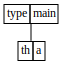

In [124]:
ast = src2ast('2 + 3 x 4')
blocks = atw_blocks(ast)
parent_to_calc = atw_prior(blocks[0][1])
tex, _ = atw_latex_formatter(ast)
display_latex(tex)
children = [Tree({'type': 'atomExpr', 'value': atw_eval(child), 'priority': 0, '_calc': 'last'}, []) 
            if is_next_to_calc(child) 
            else child 
            for child in parent_to_calc.children]

index = [i for i, item in enumerate(parent_to_calc.children) if is_next_to_calc(item)][0]

child_to_calc = parent_to_calc.children[index]

#parent_to_calc.children[index] = Tree({'type': 'atomExpr', 'value': atw_eval(child_to_calc), 'priority': 0, '_calc': 'last'}, []) 
ast.children[0] = Tree({'th': 'a'}, [])
ast
#atw_eval(priority_ast)

In [65]:
atw_eval = AnnotatedTreeWalker('type')

ARITH_OP = {
    '+' : add,
    '-' : sub,
    'x' : mul,
    ':' : Fraction,
    '/' : Fraction
}


@atw_eval.register
def atomExpr(visit, ast):
    return ast.root['value']

@atw_eval.register
def subExpr(visit, ast):
    return MEMORY[ast.root['ID']]

@atw_eval.register
def addSubExpr(visit, ast):
    left, right = ast.children
    op = ast.root['op']
    left, right = visit(left), visit(right)
    ARITH_OP[op](left, right)

@atw_eval.register
def divProdExpr(visit, ast):
    left, right = ast.children
    op = ast.root['op']
    left, right = visit(left), visit(right)
    ARITH_OP[op](left, right)
    
@atw_eval.register
def powExpr(visit, ast):
    left, right = ast.children
    left, right = visit(left), visit(right)
    value = pow(left, right) if right > 0 else Fraction(1, pow(left, -right))
    return value

@atw_eval.register
def unaryExpr(visit, ast):
    value = visit(ast.children[0])
    if ast.root['op'] == '-':
        value = -value
    return value

@atw_eval.register
def fractExpr(visit, ast):
    left, right = ast.children
    left, right = visit(left), visit(right)
    return Fraction(left, right)

@atw_eval.register
def main(visit, ast):
    return visit(ast.children[0])


In [ ]:
pow(-3, -3)
Fraction(1, pow(-3, 3))

In [ ]:
src = '(2 + 2) + {3 + 2} + [(-5)]'
src2ast(src)

In [ ]:
src = '2^-2'

ast = src2ast(src)
tex, _ = atw_latex_formatter(ast)
display_latex(tex)
while ast.children:
    #display(ast)
    ast = atw_eval(ast)
    tex, _ = atw_latex_formatter(ast)
    display_latex(tex)
    #print(100*'-')



In [ ]:
atw_depth = AnnotatedTreeWalker('type', AnnotatedTreeWalker.RECOURSE_CHILDREN)

def find_more_priority_child(ast):
    priorities = [child.root['priority'] if 'priority' in child.root else -1 for child in ast.children]
    grades = [child.root['grade'] for child in ast.children]
    l = list(zip(priorities, grades))
    return l.index(max(l, key=lambda x: float(f'{x[0]}.{x[1]}')))


@atw_depth.register
def roundBlockExpr(visit, ast):
    visit(ast.children[0])


@atw_depth.register
def squareBlockExpr(visit, ast):
    visit(ast.children[0])


@atw_depth.register
def graphBlockExpr(visit, ast):
    visit(ast.children[0])

In [ ]:
atw_depth = AnnotatedTreeWalker('type', AnnotatedTreeWalker.RECOURSE_CHILDREN)

def find_more_priority_child(ast):
    priorities = [child.root['priority'] if 'priority' in child.root else -1 for child in ast.children]
    grades = [child.root['grade'] for child in ast.children]
    l = list(zip(priorities, grades))
    return l.index(max(l, key=lambda x: float(f'{x[0]}.{x[1]}')))


@atw_depth.register
def roundBlockExpr(visit, ast):
    visit(ast.children[0])


@atw_depth.register
def squareBlockExpr(visit, ast):
    visit(ast.children[0])


@atw_depth.register
def graphBlockExpr(visit, ast):
    visit(ast.children[0])

In [ ]:
a = {2,3, 5}
b = {1, 2, 3}
a ^ b

In [ ]:
def step(ast):
    res, _ = atw_eval(ast)
    return res

In [50]:
atw_latex_formatter = AnnotatedTreeWalker('type')



@atw_latex_formatter.register
def atomExpr(visit, ast):
    fr = Fraction(ast.root['value'])
    res = str(fr)
    if fr.denominator != 1:
        res = f'\\frac{{{fr.numerator}}} {{{fr.denominator}}}'
    if '_calc' in ast.root and ast.root['_calc'] == 'last':
        res = f'\\color{{green}}{{\\boxed{{{res}}}}}'
    return res, False
    
@atw_latex_formatter.register
def addSubExpr(visit, ast):
    op = ast.root['op']
    
    left, right = ast.children
    left, left_calculable = visit(left)
    right, right_calculable = visit(right)
    
    if '_calc' in ast.root and ast.root['_calc'] == 'next':
        return f'\\color{{red}}{{\\boxed{{{left}{op}{right}}}}}', True
    return f'{left} {op} {right}', left_calculable or right_calculable
    
    
@atw_latex_formatter.register
def divProdExpr(visit, ast):
    op = ast.root['op']
    
    left, right = ast.children
    
    left, left_calculable = visit(left)
    right, right_calculable = visit(right)

    if op == 'x':
        op = '\\times'
        
    if '_calc' in ast.root and ast.root['_calc'] == 'next':
        return f'\\color{{red}}{{\\boxed{{{left}{op}{right}}}}}', True
    return f'{left} {op} {right}', left_calculable or right_calculable


@atw_latex_formatter.register
def powExpr(visit, ast):
    left, right = ast.children
    
    left, left_calculable = visit(left)
    right, right_calculable = visit(right)
    
    if '_calc' in ast.root and ast.root['_calc'] == 'next':
        return f'\\color{{red}}{{\\boxed{{{{{left}}}^{{{right}}}}}}}', True
    return f'{{{left}}}^{{{right}}}', left_calculable or right_calculable

@atw_latex_formatter.register
def unaryExpr(visit, ast):
    child, child_calculable = visit(ast.children[0])
    
    if '_calc' in ast.root and ast.root['_calc'] == 'next':
        return f'\\color{{red}}{{\\boxed{{-{child}}}}}', True
    return f'-{child}', child_calculable

@atw_latex_formatter.register
def fractExpr(visit, ast):
    
    left, right = ast.children
    
    left, left_calculable = visit(left)
    right, right_calculable = visit(right)
    
    if '_calc' in ast.root and ast.root['_calc'] == 'next':
        return f'\\color{{red}}{{\\boxed{{\\frac{{{left}}} {{{right}}}}}}}', True
    return f'\\frac{{{left}}} {{{right}}}', left_calculable or right_calculable


@atw_latex_formatter.register
def roundBlockExpr(visit, ast):
    child, calc = visit(ast.children[0])
    if calc:
        return f'\\color{{blue}}{{\\left({child}\\right)}}', False
    return f'\\left({child}\\right)', False


@atw_latex_formatter.register
def squareBlockExpr(visit, ast):
    child, calc = visit(ast.children[0])
    if calc:
        return f'\\color{{blue}}{{\\left[{child}\\right]}}', False
    return f'\\left[{child}\\right]', False


@atw_latex_formatter.register
def curlyBlockExpr(visit, ast):
    child, calc = visit(ast.children[0])
    if calc:
        return f'\\color{{blue}}{{\\left\\{{{child}\\right\\}}}}', False
    return f'\\left\\{{{child}\\right\\}}', False


@atw_latex_formatter.register
def main(visit, ast):
    return visit(ast.children[0])

In [ ]:
expr = '1 x 8 x 7 x (8 + 7) + (9 x 7 + 8 - (3 + 2+ 3))) - (8 + 9 + 8 + (4))'
ex1 = '1 + (2 x ((3 + 4 : 2) + 5) x 6) - (7 + (1 + 8) : 3) x(9 : (2 + 1) +2)'
ex2 = '<2+3>/4/<5+6>/7'
ex3 = '2^<3+4^5:2^7>'
ex4 = '3 + 13 x -<1 + 3>/<2^<1+4> - 6>'
ex5a = '3 / < 4 + 2 > + 2 x { 3 : ( 4 + 5 ) + 2 ^ < 6 x 1/2 > } - < 2 x [ 5 x ( 3 + 4 ) + 5 ] - 1 > / 6'
ex5b = '3 / < 4 + 2 > + 2 x ( 3 : ( 4 + 5 ) + 2 ^ < 6 x 1/2 > ) - < 2 x ( 5 x ( 3 + 4 ) + 5 ) - 1 > / 6'
#expr = ex1
expr = '2^-4'

ast = src2ast(expr)
#step(ast)
#step(ast)
count = 0
while ast.children:
    #display(ast)
    atw_priority(ast)
    tex, _ = atw_latex_formatter(ast)
    display_latex(tex)
    ast = atw_step(ast)
    count += 1
    #print('-' * 100)

tex, _ = atw_latex_formatter(ast)
display_latex(tex)

In [ ]:
expr = ex5a
ast = src2ast(expr)
atw_priority(ast)

text, _ = atw_latex_formatter(ast)
text
display_latex(text)


In [ ]:
display_latex(f"""
{{2}}^{{3+2x3 : 5}}
""")


In [ ]:
True or False

In [ ]:
atw_eval = AnnotatedTreeWalker('type')

ARITH_OP = {
    '+' : add,
    '-' : sub,
    'x' : mul,
    ':' : Fraction,
    '/' : Fraction
}



def find_more_priority_child(ast):
    priorities = [child.root['priority'] if 'priority' in child.root else -1 for child in ast.children]
    grades = [child.root['grade'] for child in ast.children]
    l = list(zip(priorities, grades))
    return l.index(max(l, key=lambda x: float(f'{x[0]}.{x[1]}')))


def is_calculable(ast):
    return ast.root['type'] == 'atomExpr' or all(child.root['type'] == 'atomExpr' for child in ast.children)


@atw_eval.register
def atomExpr(visit, ast):
    grade = 0
    return Tree({'type': ast.root['type'], 'value': ast.root['value'], 'grade': grade}, []), 0

@atw_eval.register
def addSubExpr(visit, ast):
    op = ast.root['op']
    
    if is_calculable(ast):  
        left, right = ast.children
        left, _ = visit(left)
        right, _ = visit(right)
        
        value = ARITH_OP[op](left.root['value'], right.root['value'])
        grade = 0
        return Tree({'type': 'atomExpr', 'value': value, 'grade': grade}, []), 0
    
    
    index_priority_child = find_more_priority_child(ast)
    children = ast.children.copy()
    children[index_priority_child], _ = visit(ast.children[index_priority_child])
    
    grade = max([child.root['grade'] for child in children if 'grade' in child.root] + [0])
    
    priority = max([child.root['priority'] for child in children if 'priority' in child.root] + [PRIORITY['addSubExpr']])
    
    res = Tree({'type': 'addSubExpr', 'op': op, 'grade' : grade, 'priority': priority}, children)
    
    if is_calculable(res) and ast.children[index_priority_child].root['type'] == 'addSubExpr':
        return visit(res)
    return res, priority
    
    
    

@atw_eval.register
def divProdExpr(visit, ast):
    op = ast.root['op']
    
    if is_calculable(ast):  
        left, right = ast.children
        left, _ = visit(left)
        right, _ = visit(right)

        value = ARITH_OP[op](left.root['value'], right.root['value'])
        grade = 0
        return Tree({'type': 'atomExpr', 'value': value, 'grade': grade}, []), 0
    
    
    index_priority_child = find_more_priority_child(ast)
    children = ast.children.copy()
    children[index_priority_child], _ = visit(ast.children[index_priority_child])
    
    grade = max([child.root['grade'] for child in children if 'grade' in child.root] + [0])
    
    priority = max([child.root['priority'] for child in children if 'priority' in child.root] + [PRIORITY['divProdExpr']])

    res = Tree({'type': 'divProdExpr', 'op': op, 'grade' : grade, 'priority': priority}, children)
    
    if is_calculable(res) and ast.children[index_priority_child].root['type'] == 'divProdExpr':
        return visit(res)
    return res, priority


@atw_eval.register
def powExpr(visit, ast):
    if is_calculable(ast):  
        left, right = ast.children
        left, _ = visit(left)
        right, _ = visit(right)

        value = pow(left.root['value'], right.root['value'])
        grade = 0
        return Tree({'type': 'atomExpr', 'value': value, 'grade': grade}, []), 0
    
    
    index_priority_child = find_more_priority_child(ast)
    children = ast.children.copy()
    children[index_priority_child], _ = visit(ast.children[index_priority_child])
    
    grade = max([child.root['grade'] for child in children if 'grade' in child.root] + [0])
    
    priority = max([child.root['priority'] for child in children if 'priority' in child.root] + [PRIORITY['powExpr']])
    return Tree({'type': 'powExpr', 'grade' : grade, 'priority': priority}, children), priority



@atw_eval.register
def unaryExpr(visit, ast):
    if is_calculable(ast):  
        subexpr, _ = visit(ast.children[0])
        
        value = subexpr.root['value']
        if ast.root['op'] == '-':
            value = -value
        grade = 0
        return Tree({'type': 'atomExpr', 'value': value, 'grade': grade}, []), 0
    
    
    
    subexpr, grade = visit(ast.children[0])
    
    if 'priority' in subexpr.root:
    else:    
        priority = PRIORITY['unaryExpr']
    return Tree({'type': 'unaryExpr', 'op': ast.root['op'],'grade' : grade, 'priority': priority}, [subexpr]), priority


@atw_eval.register
def fractExpr(visit, ast):
    if is_calculable(ast):  
        left, right = ast.children
        left, _ = visit(left)
        right, _ = visit(right)

        value = Fraction(left.root['value'], right.root['value'])
        grade = 0
        return Tree({'type': 'atomExpr', 'value': value, 'grade': grade}, []), 0
    
    
    index_priority_child = find_more_priority_child(ast)
    children = ast.children.copy()
    children[index_priority_child], _ = visit(ast.children[index_priority_child])
    
    grade = max([child.root['grade'] for child in children if 'grade' in child.root] + [0])
    
    priority = max([child.root['priority'] for child in children if 'priority' in child.root] + [PRIORITY['fractExpr']])
    return Tree({'type': 'fractExpr', 'grade' : grade, 'priority': priority}, children), priority

@atw_eval.register
def roundBlockExpr(visit, ast):
    child, child_priority = visit(ast.children[0])
    grade_block = child.root['grade'] + 1
    priority = PRIORITY['roundBlockExpr']
    res = Tree({'type': 'roundBlockExpr', 'grade': grade_block, 'priority': priority}, [child])
    if is_calculable(res):
        return child, child_priority
    return res, priority


@atw_eval.register
def squareBlockExpr(visit, ast):
    child, child_priority = visit(ast.children[0])
    grade_block = child.root['grade'] + 1
    priority = PRIORITY['squareBlockExpr']
    res = Tree({'type': 'squareBlockExpr', 'grade': grade_block, 'priority': priority}, [child])
    if is_calculable(res):
        return child, child_priority
    return res, priority

@atw_eval.register
def graphBlockExpr(visit, ast):
    child, child_priority = visit(ast.children[0])
    grade_block = child.root['grade'] + 1
    priority = PRIORITY['graphBlockExpr']
    res = Tree({'type': 'graphBlockExpr', 'grade': grade_block, 'priority': priority}, [child])
    if is_calculable(res):
        return child, child_priority
    return res, priority


In [ ]:
latex_formatter = AnnotatedTreeWalker('type')

@latex_formatter.register
def atomExpr(visit, ast):
    fr = Fraction(ast.root['value'])
    res = str(fr)
    if fr.denominator != 1:
        res = f'\\frac{{{fr.numerator}}} {{{fr.denominator}}}'
    if '_calc' in ast.root and ast.root['_calc'] == 'last':
        res = f'\\color{{green}}{{\\boxed{{{res}}}}}'
    return res, False
    
@latex_formatter.register
def addSubExpr(visit, ast):
    op = ast.root['op']
    
    left, right = ast.children
    left, left_calculable = visit(left)
    right, right_calculable = visit(right)
    
    if '_calc' in ast.root and ast.root['_calc'] == 'next':
        return f'\\color{{red}}{{\\boxed{{{left}{op}{right}}}}}', True
    return f'{left} {op} {right}', left_calculable or right_calculable
    
    
@latex_formatter.register
def divProdExpr(visit, ast):
    op = ast.root['op']
    
    left, right = ast.children
    
    left, left_calculable = visit(left)
    right, right_calculable = visit(right)

    if op == 'x':
        op = '\\times'
        
    if '_calc' in ast.root and ast.root['_calc'] == 'next':
        return f'\\color{{red}}{{\\boxed{{{left}{op}{right}}}}}', True
    return f'{left} {op} {right}', left_calculable or right_calculable


@latex_formatter.register
def powExpr(visit, ast):
    left, right = ast.children
    
    left, left_calculable = visit(left)
    right, right_calculable = visit(right)
    
    if '_calc' in ast.root and ast.root['_calc'] == 'next':
        return f'\\color{{red}}{{\\boxed{{{{{left}}}^{{{right}}}}}}}', True
    return f'{{{left}}}^{{{right}}}', left_calculable or right_calculable

@latex_formatter.register
def unaryExpr(visit, ast):
    child, child_calculable = visit(ast.children[0])
    
    if '_calc' in ast.root and ast.root['_calc'] == 'next':
        return f'\\color{{red}}{{\\boxed{{-{child}}}}}', True
    return f'-{child}', child_calculable

@latex_formatter.register
def fractExpr(visit, ast):
    
    left, right = ast.children
    
    left, left_calculable = visit(left)
    right, right_calculable = visit(right)
    
    if '_calc' in ast.root and ast.root['_calc'] == 'next':
        return f'\\color{{red}}{{\\boxed{{\\frac{{{left}}} {{{right}}}}}}}', True
    return f'\\frac{{{left}}} {{{right}}}', left_calculable or right_calculable


@latex_formatter.register
def roundBlockExpr(visit, ast):
    child, calc = visit(ast.children[0])
    if calc:
        return f'\\color{{blue}}{{\\left({child}\\right)}}', False
    return f'\\left({child}\\right)', False


@latex_formatter.register
def squareBlockExpr(visit, ast):
    child, calc = visit(ast.children[0])
    if calc:
        return f'\\color{{blue}}{{\\left[{child}\\right]}}', False
    return f'\\left[{child}\\right]', False


@latex_formatter.register
def curlyBlockExpr(visit, ast):
    child, calc = visit(ast.children[0])
    if calc:
        return f'\\color{{blue}}{{\\left\\{{{child}\\right\\}}}}', False
    return f'\\left\\{{{child}\\right\\}}', False


@latex_formatter.register
def main(visit, ast):
    return visit(ast.children[0])

